In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.patches import Patch

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [56]:

'''

Accessing data from Folder, splitting data into train/test

'''

football_data = pd.read_excel("TOTAL_DATA_FINAL.xlsx", index_col='Squad').drop(columns = ['xGD', 'KP'])

football_data = football_data.loc[ (football_data.league == 'serie_a') | (football_data.league == 'la_liga') | (football_data.league == 'premier')].drop(columns = ['league'])

cutoff = len(football_data) - 60

football_train = football_data[:cutoff]
football_test = football_data[cutoff:]


In [61]:

'''

Splitting data into X,Y and adding labels.  

'''


label_types = np.select([football_data["Rk"].values <= 4,
                          (football_data["Rk"].values > 4) & (football_data["Rk"].values <= 15),
                          (football_data["Rk"].values > 15)], [1,2,3])


X_train = football_train[[i for i in football_test.columns if i != "Rk" and i != 'league']]
Y_train = label_types[:cutoff]

X_test = football_test[[i for i in football_test.columns if i != "Rk" and i != 'league']]
Y_test = label_types[cutoff:]



0.7

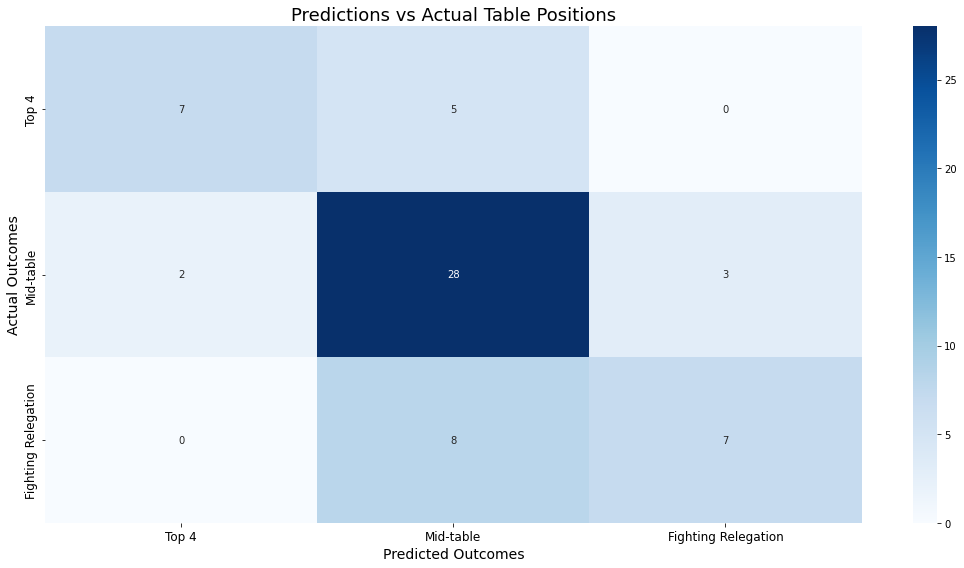

In [55]:

'''

Fitting data to algorithm, running algorithm, and plotting 

'''


forest = RandomForestClassifier(n_estimators = 100).fit(X_train, Y_train)

preds = forest.predict(X_test)
confusion = confusion_matrix(Y_test, preds)

plt.figure(figsize=(15,8))
fig = sns.heatmap(confusion, annot=True, cmap='Blues')
fig.set_xticklabels(['Top 4', 'Mid-table', 'Fighting Relegation'], size = 12)
fig.set_yticklabels(['Top 4', 'Mid-table', 'Fighting Relegation'], size = 12)
fig.set_title("Predictions vs Actual Table Positions", size = 18)
fig.set_xlabel("Predicted Outcomes", size = 14)
fig.set_ylabel("Actual Outcomes", size = 14)
plt.tight_layout()

accuracy_score(Y_test, preds)


In [79]:

'''

Top 10 features explained:

('Performance', 'CS%') = Total Saves / Percentage of Shots Saved

('Receiving', 'Prog') = Completed Passes that move the ball towards the opponent's goal within 25 yards in 6 passes or less

1/3 = Carries that enter the final third of the opponents side

('Performance', 'CS%') = Total Saves

Prog = Passes into the opponent's box

('Body Parts', 'Right') = Passes with the right foot

('Standard', 'SoT') = Shots on Target

('Carries', 'Carries') = Carries (running with the ball)

('Outcomes', 'Cmp') = Completed Passes

('Medium', 'Cmp') = Completed Passes of 15-30 yards
'''

feature_names = ["Total Saves / Percentage of Shots Saved", "Progressions to opponents goal in less than 6 passes", 
                 "Carries that Enter Opponent's Final Third", "Total Saves", "Passes into the opponent's box",
                 "Passes with the right foot", "Shots on Target", "Carries (running with the ball)", 
                 "Completed Passes", "Completed Passes of 15-30 yards"]


impact = pd.Series(forest.feature_importances_, index = [i for i in football_data.columns if i != "Rk"]).sort_values(ascending=False)


top_10 = pd.Series(impact[:10].to_list(), index = feature_names)

impact[:10]

('Performance', 'CS%')     0.051968
('Receiving', 'Prog')      0.043996
1/3                        0.039807
('Performance', 'CS')      0.038198
Prog                       0.032138
('Body Parts', 'Right')    0.025762
('Standard', 'SoT')        0.022975
('Carries', 'Carries')     0.021456
('Outcomes', 'Cmp')        0.020401
('Medium', 'Cmp')          0.018801
dtype: float64

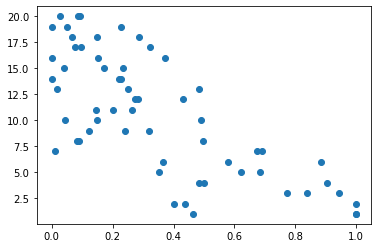

In [81]:


plt.scatter(X_test['Prog'], football_test['Rk'])



In [51]:

'''

Assessing Impact of Variables 

'''

reg = LinearRegression().fit(X_train, Y_train)

stds = np.array(football_data[[i for i in football_data.columns if i != "Rk"]].std().to_list())

impact = abs(reg.coef_ * stds)

impact = pd.Series(impact, index = [i for i in football_data.columns if i != "Rk"])


impact.sort_values(ascending=False)[:10]

('Receiving', 'Rec')      81.871103
('Outcomes', 'Cmp')       40.353421
('Total', 'Cmp')          40.353421
('Standard', 'Sh')         2.427916
('Standard', 'Sh/90')      2.335743
('Receiving', 'Targ')      2.293775
('Standard', 'SoT')        1.815323
('Standard', 'SoT/90')     1.709213
('Touches', 'Touches')     1.683515
('Performance', 'CS%')     0.859201
dtype: float64

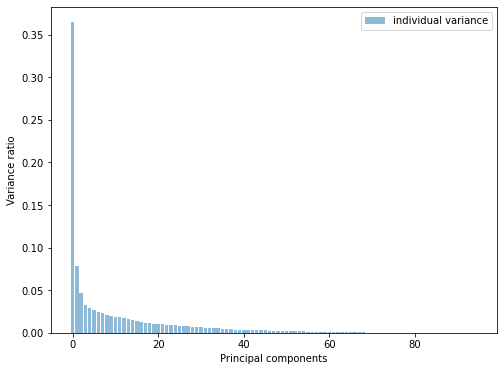

In [62]:

X_features = football_data[[i for i in football_data.columns if i != "Rk"]]
Y_Test = label_types

pca = PCA()
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(95), pca_variance, alpha=0.5, align='center', label='individual variance')
#plt.yscale('log')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()


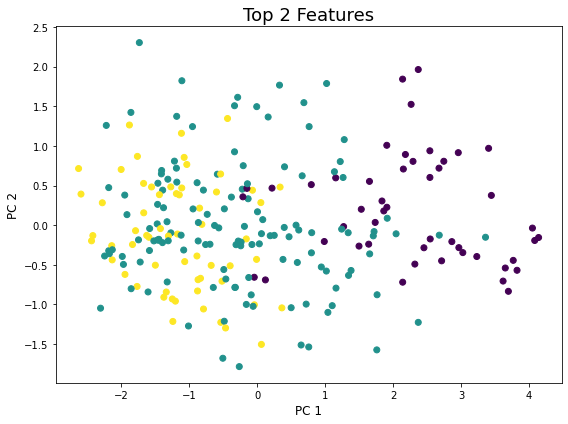

In [67]:

pca2 = PCA(n_components=2)
pca2.fit(X_features)
x_3d = pca2.transform(X_features)
plt.figure(figsize=(8,6))
plt.scatter(x_3d[:,0], x_3d[:,1], c=label_types)
plt.title("Top 2 Features", size = 18)
plt.xlabel("PC 1", size = 12)
plt.ylabel("PC 2", size = 12)
plt.tight_layout()